# Sample Coding Exercise : Interpolation
- https://www.hackerrank.com/contests/intro-to-statistics/challenges/temperature-predictions/problem
- Take care with 2-D: you may need to use the correlation in the variables to improve the fit!\
![title](img/TempCorrelation.png) 

In [1]:
%matplotlib inline
from IPython.core.display import display, HTML 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas_profiling
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
plt.rc("font", size=14)

/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packag

In [2]:
import os, sys, re
import calendar
import collections
from collections import defaultdict, OrderedDict

from scipy.stats import linregress

from datetime import datetime
from dateutil.relativedelta import *
import itertools
from dateutil import parser

import pandas as pd
pd.set_option('display.max_columns', 100)

import numpy as np
import scipy
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import sympy
import requests
from bs4 import BeautifulSoup
from scipy.stats import mode
from scipy import interp

from sklearn import preprocessing, linear_model, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
## Data I/O Test Data Provided
- Input: I am reading in the data from copy paste from the website
- Output: ordered list printed to terminal
    
    #! note copy from keyboard will turn columns to strings

In [3]:
df = pd.read_clipboard(header = 0)
display(df)

,yyyy,month,tmax,tmin
0,1908,January,5.0,-1.4
1,1908,February,7.3,1.9
2,1908,March,6.2,0.3
3,1908,April,Missing_1,2.1
4,1908,May,Missing_2,7.7
5,1908,June,17.7,8.7
6,1908,July,Missing_3,11.0
7,1908,August,17.5,9.7
8,1908,September,16.3,8.4
9,1908,October,14.6,8.0


In [41]:
df_answer = pd.read_clipboard(header = None)
df_answer = pd.to_numeric(df_answer[0])
df_answer = df_answer.to_frame("truth")
display(df_answer)

,truth
0,8.6
1,15.8
2,18.9
3,0.0


## Treat missing values in a standard way

In [81]:
df2 = df.copy(deep = True)
df2[["tmax_clean", "tmin_clean"]] = df2[["tmax", "tmin"]].replace(to_replace= r'(?i)missing', value=np.nan, regex= True)

df2["tmax_clean"] = df2["tmax_clean"].apply(pd.to_numeric)
df2["tmin_clean"] = df2["tmin_clean"].apply(pd.to_numeric)
df2.head(15)

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean
0,1908,January,5.0,-1.4,5.0,-1.4
1,1908,February,7.3,1.9,7.3,1.9
2,1908,March,6.2,0.3,6.2,0.3
3,1908,April,Missing_1,2.1,NaN,2.1
4,1908,May,Missing_2,7.7,NaN,7.7
5,1908,June,17.7,8.7,17.7,8.7
6,1908,July,Missing_3,11.0,NaN,11.0
7,1908,August,17.5,9.7,17.5,9.7
8,1908,September,16.3,8.4,16.3,8.4
9,1908,October,14.6,8.0,14.6,8.0


### Convert to datetime index

In [82]:
d = {"month", dict(zip(pd.date_range('2000-01-01', freq='M', periods=12).strftime('%B'), range(1,13)))}

# df2["month_number"] = df2["month"].replace(d)  Does not work in pandas 0.19
for idx,row in df2.iterrows():
    df2.loc[idx, "month_number"] = d[row["month"]]

df2["yyyy"] = df2["yyyy"].map(str)
df2["date_time"] = df2['month'] + "-" + df2["yyyy"]
df2["date_time"]  = df2["date_time"].apply(lambda x: pd.to_datetime(x,format = '%B-%Y'))
df2.set_index("date_time", inplace = True)

#pandas_profiling.ProfileReport(df2[["tmax_clean", "tmin_clean", "month_number"]])

# Correlation among the Temperature Min and Max Values

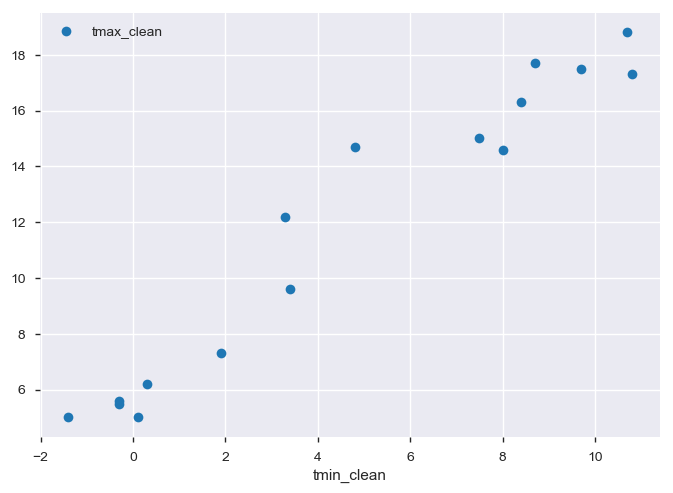

In [17]:
df2.plot(x='tmin_clean', y='tmax_clean', style='o')

# Perform Linear interpolation  [tmin,tmax]
- leverage the correlation in the data

In [50]:
df_answer = df_answer["truth"]

1.1810477523176492 6.1882993702991085


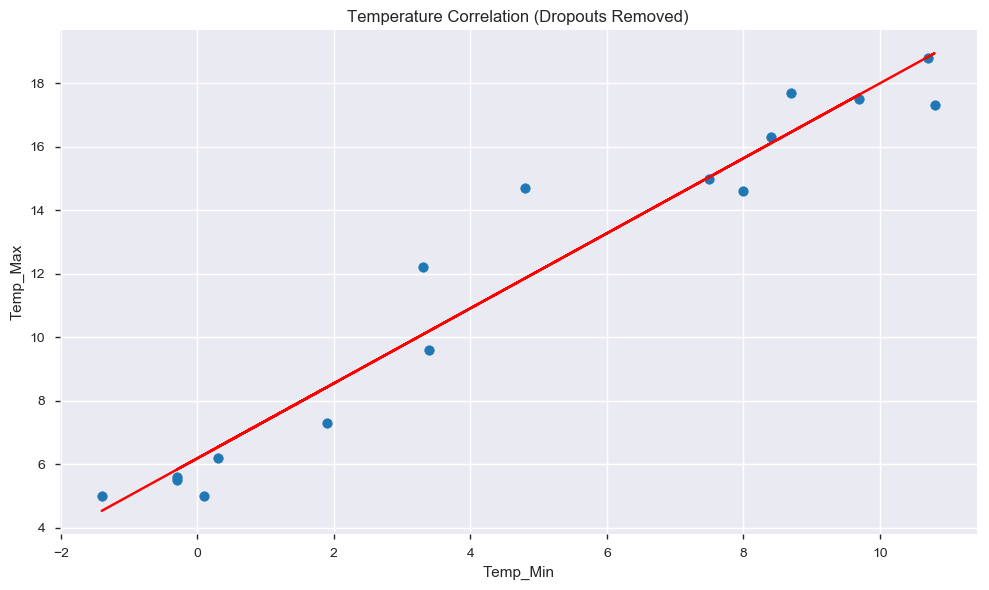

OrderedDict([('Missing_1', 8.668499650166172), ('Missing_2', 15.282367063145006), ('Missing_3', 19.17982464579325), ('Missing_4', -0.32877533489829075)])

8.668499650166172
15.282367063145006
19.17982464579325
-0.32877533489829075


,truth,answer_lreg,delta_lreg2
0,8.6,8.668500,-0.068500
1,15.8,15.282367,0.517633
2,18.9,19.179825,-0.279825
3,0.0,-0.328775,0.328775


In [51]:
x = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"]).tmin_clean.values
y = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"]).tmax_clean.values

stats = linregress(x, y)

m = stats.slope
b = stats.intercept
print(m,b)

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.scatter(x, y)
plt.plot(x, m * x + b, color="red")   # I've added a color argument here

ax2.set_title("Temperature Correlation (Dropouts Removed)")
ax2.set_ylabel("Temp_Max")
ax2.set_xlabel("Temp_Min")
plt.tight_layout()
plt.savefig("TempCorrelation.png")
plt.show()

my_dict = OrderedDict()
for idx, row in df2.iterrows():
    if (("Missing" in row["tmin"]) & (not "Missing" in row["tmax"])):
        my_dict[row["tmin"]] = 1/float(m)*(row["tmax_clean"] - b)
    if (("Missing" in row["tmax"]) & (not "Missing" in row["tmin"])):
        my_dict[row["tmax"]] = m * row["tmin_clean"] + b
        
print(my_dict)
my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)

df_answer = pd.concat([df_answer, pd.DataFrame(my_list, columns= ["answer_lreg",])], axis = 1)
df_answer["delta_lreg2"] = df_answer["truth"] - df_answer["answer_lreg"]

df_answer

## SciKit Learn Fit based on [month_number, tmin, tmax] ignoring the year.
 - Use data without Nan's as the training set
 - Use the tmin = nan as those to predict based on [month_number, tmax]
 - Use the tmax = nan as those to predict based on [month_number, tmin]

In [73]:
df_train = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"])
df_train = df_train[["month_number", "tmax_clean", "tmin_clean"]]

df_test = df2[df2[["tmin_clean", "tmax_clean"]].isnull().any(axis=1)]
df_test = df_test[["month_number", "tmax_clean", "tmin_clean"]]

X_train = df_train[["month_number", "tmax_clean"]].values
Y_train = df_train["tmin_clean"].values
X_mintest = df_test[df_test["tmin_clean"].isnull()][["month_number", "tmax_clean"]].values

reg = LinearRegression()
model = reg.fit(X_train, Y_train)
tmin_predict = model.predict(X_mintest) 

X_train = df_train[["month_number", "tmin_clean"]].values
Y_train = df_train["tmax_clean"].values
X_maxtest = df_test[df_test["tmax_clean"].isnull()][["month_number", "tmin_clean"]].values

reg = LinearRegression()
model = reg.fit(X_train, Y_train)

tmax_predict = model.predict(X_maxtest) 

df_sklearn = df2.copy(deep = True)
df_sklearn["tmax_hat"] = df_sklearn["tmax_clean"]
df_sklearn["tmin_hat"] = df_sklearn["tmin_clean"]
df_sklearn.loc[df_sklearn["tmax_clean"].isnull(),"tmax_hat"] = tmax_predict
df_sklearn.loc[df_sklearn["tmin_clean"].isnull(),"tmin_hat"] = tmin_predict

my_dict = OrderedDict()
for idx, row in df_sklearn.iterrows():
    if "Missing" in row["tmin"]:
        my_dict[row["tmin"]] = row["tmin_hat"]
    if "Missing" in row["tmax"]:
        my_dict[row["tmax"]] = row["tmax_hat"]

my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)
    
df_answer = pd.concat([df_answer, pd.DataFrame(my_list, columns= ["answer_scikitreg",])], axis = 1)
df_answer["delta_scikitreg"] = df_answer["truth"] - df_answer["answer_scikitreg"]
df_answer


8.662087950728417
15.401943733483362
19.291694067282894
1.3625249040725382


# Apply Pandas built in interpolation methods
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.interpolate.html

Types of missing data:
- if upsampling is required:
      upsampled = df.series.resample('D')
- if the dates are missing
      df = df.reindex(pd.date_range("2011-01-01", "2011-10-31"), fill_value="NaN")
- if the data contains duplicates:
      df.drop_duplicates(keep = 'first', inplace = True)

- forward fill copies values forward.  Limit will impact how big a gap you will fill
https://chrisalbon.com/machine_learning/preprocessing_dates_and_times/handling_missing_values_in_time_series/
https://chrisalbon.com/python/data_wrangling/pandas_missing_data/
      
- methods: {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, 'slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’,
            ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}
            
      - method='quadratic'  if you are dealing with a time series that is growing at an increasing rate.
      - method='pchip' if you have values approximating a cumulative distribution function. 
      - method='akima': to fill missing values with goal of smooth plotting.

In [59]:
df_interp = df2.copy(deep = True)

df_interp["tmin_hat"] = df_interp["tmin_clean"].interpolate(axis=0, method='time',\
                         limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None).ffill().bfill()
df_interp["tmax_hat"] = df_interp["tmax_clean"].interpolate(axis=0, method='time',\
                        limit=None, inplace=False, limit_direction='forward', limit_area=None, downcast=None).ffill().bfill()

# Print the missing values
df_pandas = df_interp[df_interp['tmin'].str.startswith("Missing") | df_interp['tmax'].str.startswith("Missing")]

my_dict = OrderedDict()
for idx, row in df_pandas.iterrows():
    if "Missing" in row["tmin"]:
        my_dict[row["tmin"]] = row["tmin_hat"]
    if "Missing" in row["tmax"]:
        my_dict[row["tmax"]] = row["tmax_hat"]
#print(my_dict)
my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)
    
df_answer = pd.concat([df_answer, pd.DataFrame(my_list, columns= ["answer_pandasreg",])], axis = 1)
df_answer["delta_pandasreg"] = df_answer["truth"] - df_answer["answer_pandasreg"]
df_answer


10.075
13.825
17.601639344262296
1.777049180327869


,truth,answer_lreg,delta_lreg2,answer_scikitreg,delta_scikitreg,answer_pandasreg,delta_pandasreg
0,8.6,8.668500,-0.068500,8.662088,-0.062088,10.075000,-1.475000
1,15.8,15.282367,0.517633,15.401944,0.398056,13.825000,1.975000
2,18.9,19.179825,-0.279825,19.291694,-0.391694,17.601639,1.298361
3,0.0,-0.328775,0.328775,1.362525,-1.362525,1.777049,-1.777049


### Varia/tion on Pandas interpolation method

In [60]:
df_interp2 = df2.copy(deep = True)

df_interp2["tmin_hat"] = df_interp2["tmin_clean"].interpolate(method='polynomial', order=2).ffill().bfill()
df_interp2["tmax_hat"] = df_interp2["tmax_clean"].interpolate(method='polynomial', order=2).ffill().bfill()

# Print the missing values
df_pandas2 = df_interp2[df_interp2['tmin'].str.startswith("Missing") | df_interp2['tmax'].str.startswith("Missing")]

my_dict = OrderedDict()
for idx, row in df_pandas2.iterrows():
    if "Missing" in row["tmin"]:
        my_dict[row["tmin"]] = row["tmin_hat"]
    if "Missing" in row["tmax"]:
        my_dict[row["tmax"]] = row["tmax_hat"]
#print(my_dict)
my_list = list(my_dict.values())
print()
for elem in my_list:
    print(elem)
    
df_answer = pd.concat([df_answer, pd.DataFrame(my_list, columns= ["answer_pdPolyreg",])], axis = 1)
df_answer["delta_pdPolyreg"] = df_answer["truth"] - df_answer["answer_pdPolyreg"]
df_answer


8.381624067909202
13.975349515190798
18.423150274632224
0.8619823925615726


,truth,answer_lreg,delta_lreg2,answer_scikitreg,delta_scikitreg,answer_pandasreg,delta_pandasreg,answer_pdPolyreg,delta_pdPolyreg
0,8.6,8.668500,-0.068500,8.662088,-0.062088,10.075000,-1.475000,8.381624,0.218376
1,15.8,15.282367,0.517633,15.401944,0.398056,13.825000,1.975000,13.975350,1.824650
2,18.9,19.179825,-0.279825,19.291694,-0.391694,17.601639,1.298361,18.423150,0.476850
3,0.0,-0.328775,0.328775,1.362525,-1.362525,1.777049,-1.777049,0.861982,-0.861982


# SCIKIT Learn is the Winner!

## Look at the Fit Constraints
 -  1908 <=time <= 2013
 -  -75 <= Tmax/Tmin <= 75

In [75]:
df_sklearn["temp_constraint_v"] = df_sklearn["tmax_hat"]/df_sklearn["tmin_hat"]
df_sklearn[abs(df_sklearn["temp_constraint_v"]) > 75]

,yyyy,month,tmax,tmin,tmax_clean,tmin_clean,month_number,tmax_hat,tmin_hat,temp_constraint_v
date_time,,,,,,,,,,


# Check the Output by making some Residual Plots

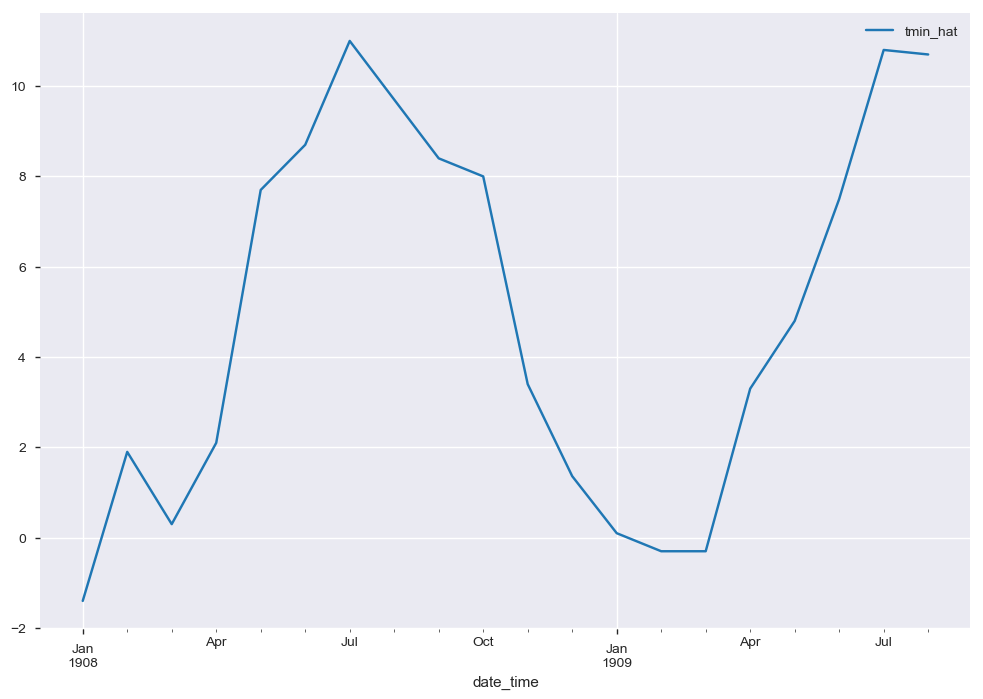

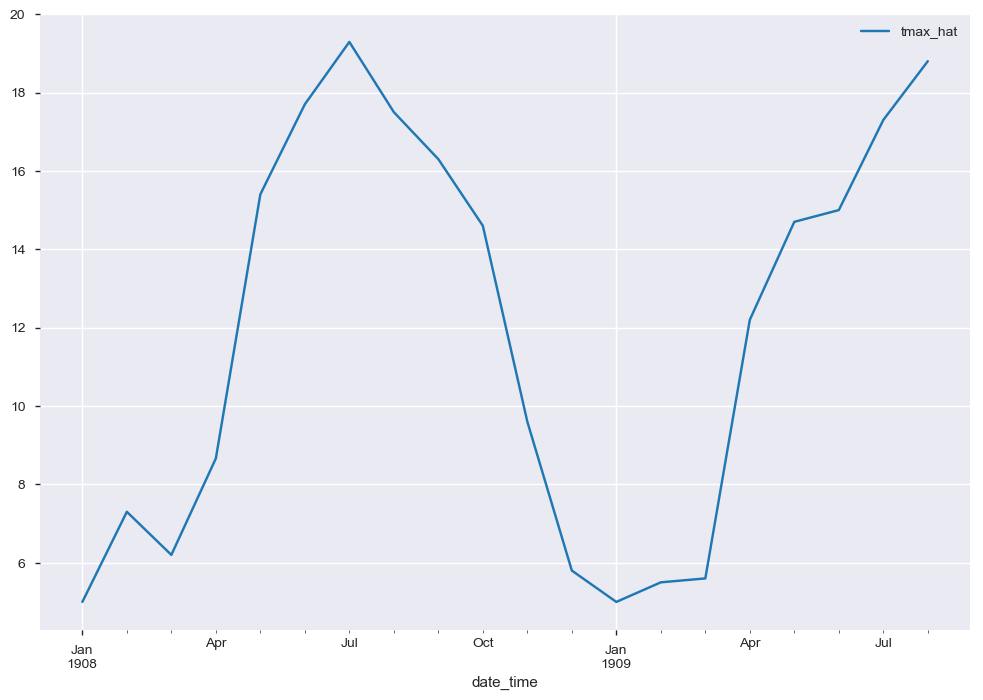

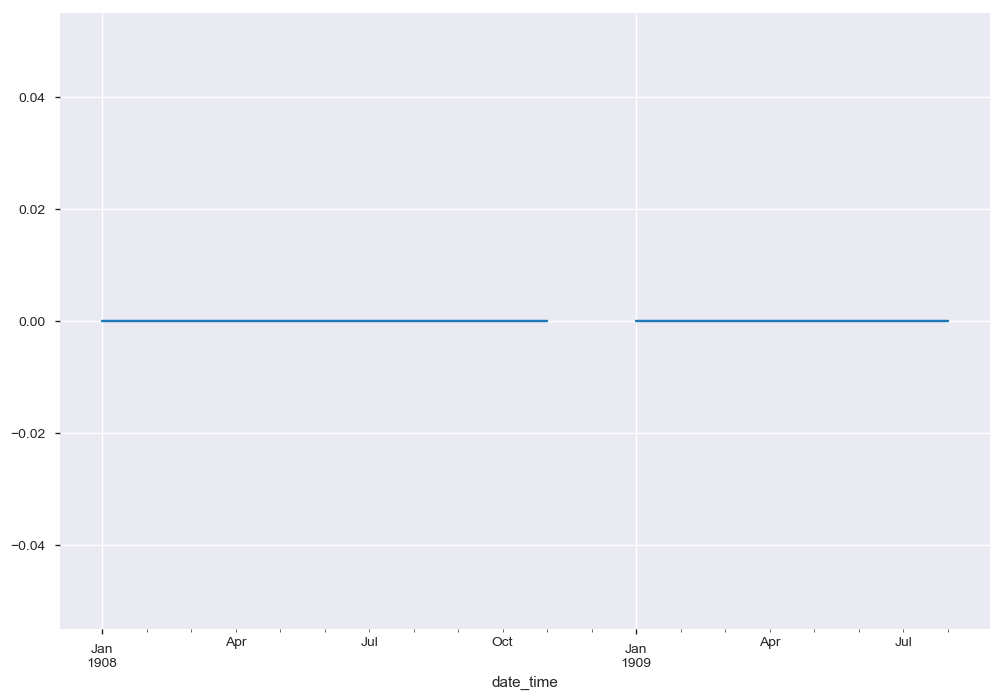

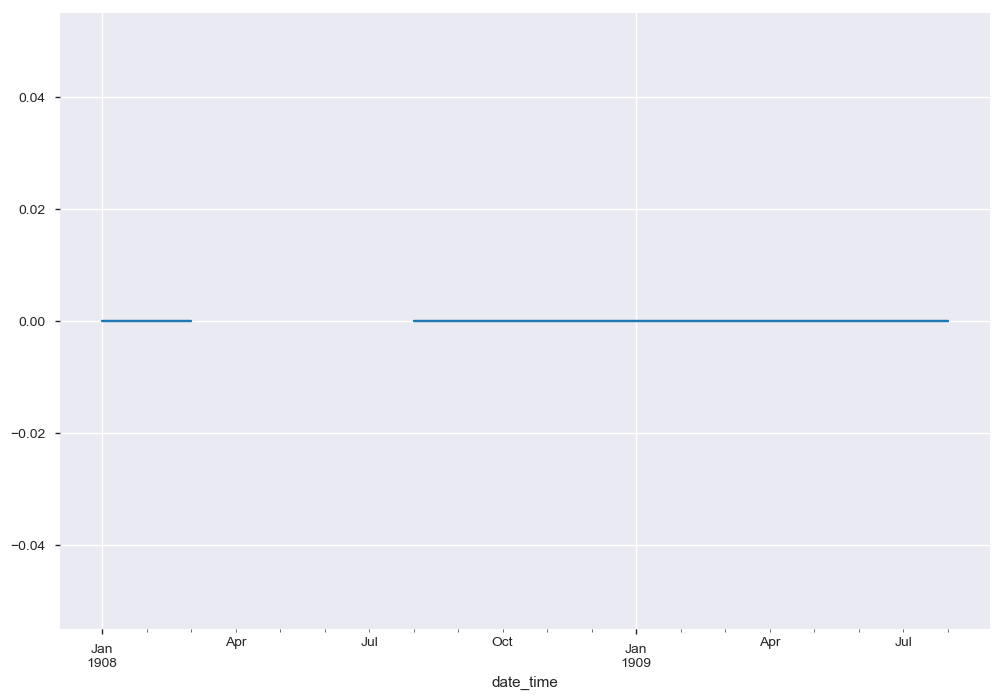

In [77]:
df_sklearn[['tmin', 'tmin_hat']].plot(figsize=(12, 8))
plt.show()

df_sklearn[['tmax', 'tmax_hat']].plot(figsize=(12, 8))
plt.show()

df_sklearn["min_resid"] = df_sklearn['tmin_clean'] - df_sklearn['tmin_hat']
df_sklearn["min_resid"].plot(figsize=(12, 8))
plt.show()

df_sklearn["max_resid"] = df_sklearn['tmax_clean'] - df_sklearn['tmax_hat']
df_sklearn["max_resid"].plot(figsize=(12, 8))
plt.show()

# SUBMITTED CODE

In [ ]:
import os, sys, re
import calendar
import collections
from collections import defaultdict, OrderedDict

from scipy.stats import linregress

from datetime import datetime
from dateutil.relativedelta import *
import itertools
from dateutil import parser

import pandas as pd
pd.set_option('display.max_columns', 100)

import numpy as np
import scipy
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import sympy
import requests
from bs4 import BeautifulSoup
from scipy.stats import mode
from scipy import interp

from sklearn import preprocessing, linear_model, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion

if __name__ == "__main__":
    # Read Data from STDIN
    t=int(sys.stdin.readline())
    my_header = sys.stdin.readline().split()

    data = sys.stdin.read().splitlines()
    data = [re.split(r'\t', l) for l in data]
    df = pd.DataFrame(data, columns= my_header)

    # PreProcess data
    df2 = df.copy(deep = True)
    df2[["tmax_clean", "tmin_clean"]] = df2[["tmax", "tmin"]].\
                                          replace(to_replace= r'(?i)missing', value=np.nan, regex= True)
    #df2["tmax_clean"] =  = df["tmax"].replace(to_replace= r'(?i)missing', value=np.nan, regex= True)
    #df2["tmin_clean"] = df["tmin"].replace(to_replace= r'(?i)missing', value=np.nan, regex= True)

    df2["tmax_clean"] = df2["tmax_clean"].apply(pd.to_numeric)
    df2["tmin_clean"] = df2["tmin_clean"].apply(pd.to_numeric)


    # ### Convert to datetime index
    d = dict(zip(pd.date_range('2000-01-01', freq='M', periods=12).strftime('%B'), range(1,13)))
    for idx,row in df2.iterrows():
        df2.loc[idx, "month_number"] = d[row["month"]]
    
    df2["yyyy"] = df2["yyyy"].map(str)
    df2["date_time"] = df2['month'] + "-" + df2["yyyy"]
    df2["date_time"]  = df2["date_time"].apply(lambda x: pd.to_datetime(x,format = '%B-%Y'))
    df2.set_index("date_time", inplace = True)


    # # SciKit Learn interpolation methods

    
    df_train = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"])
    df_train = df_train[["month_number", "tmax_clean", "tmin_clean"]]

    df_test = df2[df2[["tmin_clean", "tmax_clean"]].isnull().any(axis=1)]
    df_test = df_test[["month_number", "tmax_clean", "tmin_clean"]]

    X_train = df_train[["month_number", "tmax_clean"]].values
    Y_train = df_train["tmin_clean"].values
    X_mintest = df_test[(df_test["tmin_clean"].isnull()) &\
                        (df_test["tmax_clean"].notnull())][["month_number", "tmax_clean"]].values
    reg = LinearRegression()
    model = reg.fit(X_train, Y_train)
    tmin_predict = model.predict(X_mintest) 

    X_train = df_train[["month_number", "tmin_clean"]].values
    Y_train = df_train["tmax_clean"].values
    X_maxtest = df_test[(df_test["tmax_clean"].isnull()) &\
                                (df_test["tmin_clean"].notnull())][["month_number", "tmin_clean"]].values

    reg = LinearRegression()
    model = reg.fit(X_train, Y_train)

    tmax_predict = model.predict(X_maxtest) 

    df_sklearn = df2.copy(deep = True)
    df_sklearn["tmax_hat"] = df_sklearn["tmax_clean"]
    df_sklearn["tmin_hat"] = df_sklearn["tmin_clean"]
    
    
    df_sklearn.loc[((df_sklearn["tmax_clean"].isnull()) &\
                    (df_sklearn["tmin_clean"].notnull())), "tmax_hat"] = tmax_predict
    df_sklearn.loc[((df_sklearn["tmin_clean"].isnull()) &\
                    (df_sklearn["tmax_clean"].notnull())), "tmin_hat"] = tmin_predict

    my_dict = OrderedDict()
    for idx, row in df_sklearn.iterrows():
        if "Missing" in row["tmin"]:
            my_dict[row["tmin"]] = row["tmin_hat"]
        if "Missing" in row["tmax"]:
            my_dict[row["tmax"]] = row["tmax_hat"]

    my_list = list(my_dict.values())
    print()
    for elem in my_list:
        print(elem)

# PostMortem
 - The second test failed initially b/c I did not know how to get it to read the STD input correctly.
 - Below, I downloaded that file and ran it locally here

In [132]:
df_case2 = pd.read_csv("test_case#2.tsv", sep = '\t', header = 1)
df_case2answer= pd.read_csv("answer_case#2", sep = '\t', header = None, names = ["truth"])

In [130]:
if __name__ == "__main__":

    df2 = df_case2.copy(deep = True)
    df2[["tmax_clean", "tmin_clean"]] = df2[["tmax", "tmin"]].\
                                          replace(to_replace= r'(?i)missing', value=np.nan, regex= True)
    #df2["tmax_clean"] =  = df["tmax"].replace(to_replace= r'(?i)missing', value=np.nan, regex= True)
    #df2["tmin_clean"] = df["tmin"].replace(to_replace= r'(?i)missing', value=np.nan, regex= True)

    df2["tmax_clean"] = df2["tmax_clean"].apply(pd.to_numeric)
    df2["tmin_clean"] = df2["tmin_clean"].apply(pd.to_numeric)


    # ### Convert to datetime index
    d = dict(zip(pd.date_range('2000-01-01', freq='M', periods=12).strftime('%B'), range(1,13)))
    for idx,row in df2.iterrows():
        df2.loc[idx, "month_number"] = d[row["month"]]
    
    df2["yyyy"] = df2["yyyy"].map(str)
    df2["date_time"] = df2['month'] + "-" + df2["yyyy"]
    df2["date_time"]  = df2["date_time"].apply(lambda x: pd.to_datetime(x,format = '%B-%Y'))
    df2.set_index("date_time", inplace = True)


    # # SciKit Learn interpolation methods

    
    df_train = df2.dropna(how='any',subset= ["tmin_clean", "tmax_clean"])
    df_train = df_train[["month_number", "tmax_clean", "tmin_clean"]]

    df_test = df2[df2[["tmin_clean", "tmax_clean"]].isnull().any(axis=1)]
    df_test = df_test[["month_number", "tmax_clean", "tmin_clean"]]

    X_train = df_train[["month_number", "tmax_clean"]].values
    Y_train = df_train["tmin_clean"].values
    X_mintest = df_test[(df_test["tmin_clean"].isnull()) &\
                        (df_test["tmax_clean"].notnull())][["month_number", "tmax_clean"]].values
    reg = LinearRegression()
    model = reg.fit(X_train, Y_train)
    tmin_predict = model.predict(X_mintest) 

    X_train = df_train[["month_number", "tmin_clean"]].values
    Y_train = df_train["tmax_clean"].values
    X_maxtest = df_test[(df_test["tmax_clean"].isnull()) &\
                                (df_test["tmin_clean"].notnull())][["month_number", "tmin_clean"]].values

    reg = LinearRegression()
    model = reg.fit(X_train, Y_train)

    tmax_predict = model.predict(X_maxtest) 

    df_sklearn = df2.copy(deep = True)
    df_sklearn["tmax_hat"] = df_sklearn["tmax_clean"]
    df_sklearn["tmin_hat"] = df_sklearn["tmin_clean"]
    
    
    df_sklearn.loc[((df_sklearn["tmax_clean"].isnull()) &\
                    (df_sklearn["tmin_clean"].notnull())), "tmax_hat"] = tmax_predict
    df_sklearn.loc[((df_sklearn["tmin_clean"].isnull()) &\
                    (df_sklearn["tmax_clean"].notnull())), "tmin_hat"] = tmin_predict

    my_dict = OrderedDict()
    for idx, row in df_sklearn.iterrows():
        if "Missing" in row["tmin"]:
            my_dict[row["tmin"]] = row["tmin_hat"]
        if "Missing" in row["tmax"]:
            my_dict[row["tmax"]] = row["tmax_hat"]

    my_list = list(my_dict.values())
    print()
    for elem in my_list:
        print(elem)


8.023567576598913
14.956071972588784
18.876006747611
1.4060334342946659
7.502582149144462
2.940294910002235
7.074080962002098
0.2394289909028684
12.897675794501763
5.857332293815556
0.9488187331023301
9.90315408171065
13.571314830987102
17.608417930900735
3.1853997123960625
7.124921110525822
10.559753472400955
6.397686123397952
8.770170965854728
13.740795283767309
3.7887345051962704
17.99479765750084
11.097168013436823
5.953237861611667
-0.6042969976989871
19.00189376048388
15.998042827497684
12.356038142165625
0.22528834240129836
16.978982866536334
4.165818750696401
9.030663679581954
8.914723440701952
18.2465716832466
19.262386474211105
14.990946724514643
5.857332293815556
0.1498714933012728
3.8005183504017506
9.473279484701361
15.242720750260407
1.4460985765032852
2.2309051678027734
3.543629702802444
4.856354237802115
19.388273487083985
-0.514739500097392
8.657834793102644
17.11358856739068
10.845393987691065
15.594225724934653
11.58495125950209
8.177052401499349
5.072028771501506
-

In [133]:
df_case2answer = pd.concat([df_case2answer, pd.DataFrame(my_list, columns= ["answer_scikit2",])], axis = 1)
df_case2answer["delta_scikit2"] = df_case2answer["truth"] - df_case2answer["answer_scikit2"]
df_case2answer

,truth,answer_scikit2,delta_scikit2
0,8.6,8.023568,0.576432
1,15.8,14.956072,0.843928
2,18.9,18.876007,0.023993
3,0.0,1.406033,-1.406033
4,7.0,7.502582,-0.502582
5,2.2,2.940295,-0.740295
6,6.0,7.074081,-1.074081
7,1.8,0.239429,1.560571
8,12.5,12.897676,-0.397676
9,4.8,5.857332,-1.057332
